This notebook calculates the equations of motion for a multi-link compound pendulum (ie not just a point mass)
and simulates the dynamics using `scipy.odient`. The pendulum is modeled as a uniform density rod with friction at the pivot. 

Matplotlib is used to generate images which are can then be combined into an animation.

This notebook is loosely based on [this article](http://nbviewer.jupyter.org/github/pydy/pydy/blob/master/examples/differential_drive/Differential%20Drive.ipynb)
and I looked at [the sympy test cases for more examples of using LagrangesMethod](https://github.com/sympy/sympy/blob/master/sympy/physics/mechanics/tests/test_lagrange.py).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import odeint
from sympy import symbols, lambdify, Dummy, integrate, Matrix, simplify
from sympy.physics.mechanics import *

%matplotlib inline
init_vprinting()

In [2]:
num_segments = 3
m = symbols('m:' + str(num_segments))   # mass of the pendulum
l = symbols('l:' + str(num_segments))   # length of the pendulum
g = symbols('g')   # acceleration due to gravity
mu = symbols('mu:' + str(num_segments)) # coefficient of friction

q = Matrix(dynamicsymbols('theta:' + str(num_segments))) # q is the state vector
dq = q.diff() # and dq is the velocity

In [3]:
N = ReferenceFrame('N') # Inertial Reference Frame
O = Point('O') # Define a world coordinate origin
O.set_vel(N, 0) # set the velocity of the origin to zero in the world frame

In [4]:
friction_forces  = []
segments = []
points = [O]# the first link is attached the origin. the rest are chained

x = symbols('x') # symbol for use in integration
R_prev = N
for i in xrange(num_segments):
    # create a reference frame for the pendulum
    R = N.orientnew('R' + str(i), 'Axis', [q[i], N.z])
    R.set_ang_vel(N, dq[i]*N.z) # set the angular velocity of R to dq

    # define a point for the center of mass of the pendulum
    C = points[i].locatenew('C' + str(i), R.x*l[i]/2.)
    C.v2pt_theory(points[i], N, R) # solve for and set the velocity of C

    # calculate the inertia (modeled as a uniform density stick rotating at the end)
    # integrate the density (m/l) time the radius squared along the length of the segment
    I_component = integrate(x**2 * m[i]/l[i], (x, 0, l[i]))
    # the pendulum is a 3d model, but has no Ixx inertia because it's zero diamter
    I = inertia(R, 0, I_component, I_component)

    # and define a rigid body for the segment
    segment = RigidBody('segment' + str(i), C, R, m[i], (I , points[i]))

    # calculate the potential energy of the segment
    h = (C.pos_from(O)).express(N).args[0][0][0]
    segment.potential_energy = m[i]*g*h
    segments.append(segment)
    
    # the angular velocity of each pivot is the difference between it and it's mounting point
    pivot_vel = dq[i-1] if i > 0 else 0
    # the force of friction acts on the pendulums reference frame and is proportional to dq
    force_of_friction = (R, - N.z * mu[i] * (dq[i] - pivot_vel))
    friction_forces.append(force_of_friction)
    
    # create a point for the end of the segmetn
    E = points[i].locatenew('E' + str(i), R.x*l[i])
    E.v2pt_theory(points[i], N, R) # solve for and set the velocity
    points.append(E) # set the pivot for the next segment
    R_prev = R # and save the previous reference frame

In [5]:
L = Lagrangian(N, *segments) # create the lagrangian L = T - V
lm = LagrangesMethod(L, [q], forcelist=friction_forces, frame=N)
le = lm.form_lagranges_equations()
rhs = lm.rhs() # extract the right hand side

In [6]:
class RHSWrapper():
    def __init__(self, rhs, dynamics, params=[], values=[]):
        self.rhs = rhs
        self.dynamics = dynamics
        self.params = params
        self.values = values
        
        # substitute dummy variables into the equations of motion for later evaluation
        self._dummys = [Dummy() for i in self.dynamics]
        self._dummy_dict = dict(zip(self.dynamics, self._dummys))
        self._dummy_rhs = msubs(self.rhs, self._dummy_dict)
        
        # create a function to evaluate the right hand side
        self._rhs_func = lambdify(list(self._dummys) + list(self.params), self._dummy_rhs)
    
    def step(self, x, t, values=None):
        # use the input values if provided, else use the stored values
        v = self.values if values is None else values
        assert len(v) == len(self.params)
        
        # the returned values must be a flat array for odient
        args = np.hstack([x, v])

        return np.ravel(np.array(self._rhs_func(*args)))

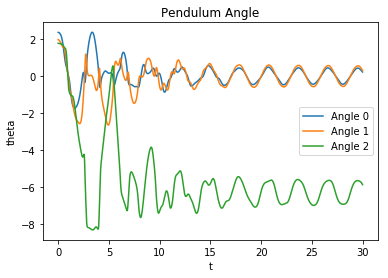

In [7]:
params = list(m) + list(l) + [g] + list(mu)
values = [1,  1, 1, 1, 1,1, -9.8,  0.1, 0.1,0.1]
# RHSWrapper handles evaluating the dynamics model 
f = RHSWrapper(rhs, list(q) + list(dq), params, values)

ts = np.linspace(0, 30, 3000) # time steps (milliseconds)
x0 = [3*np.pi/4, 5*np.pi/8, 9*np.pi/16, 0, 0, 0] # initial condition
xs = odeint(f.step, x0, ts) # run the simulation

for i in xrange(num_segments):
    plt.plot(ts, xs[:,i], label="Angle " + str(i))
plt.legend()
plt.title('Pendulum Angle')
plt.xlabel('t')
plt.ylabel('theta')

In [8]:
class PendulumDrawer():
    def __init__(self, points, inertial_frame, origin, dynamics, params, values=None):
        self.expressions_raw = [self.get_expression_for_point(p, inertial_frame, origin) for p in points]
        self.dynamics = dynamics
        self.params = params
        self.expressions = None
        if values is not None:
            self.set_values(values)
    
    def get_coords(self, dynamics_values):
        if self.expressions is None:
            print 'Use PendulumDrawer.set_values() to assign values to the parameter list'
            return []
        
        return np.hstack([msubs(e, dict(zip(self.dynamics, dynamics_values))) for e in self.expressions]).T
        
    def set_values(self, values):
        assert len(values) == len(self.params)
        print self.params
        print values
        self.expressions = [msubs(e, dict(zip(self.params, values))) for e in self.expressions_raw]
        
    def get_expression_for_point(self, point, inertial_frame, origin):
        e = point.pos_from(origin).express(inertial_frame).args
        return Matrix([0,0,0]) if len(e) == 0 else e[0][0]
        
    def get_segment_list(self, dynamics_values):
        coords = self.get_coords(dynamics_values)
        xs = zip(-coords[:-1, 0], -coords[1:, 0])
        ys = zip(coords[:-1, 1], coords[1:, 1])
        return zip(ys, xs)

In [9]:
save_location = os.path.expanduser('~/Desktop/pendulum_vid')
extension = 'png'

def get_filename(num):
    fnum = '{0:05d}'.format(num)
    return '{}/{}.{}'.format(save_location, fnum, extension)

duration = 20
fps = 30

pd = PendulumDrawer(points, N, O, list(q), params, values) # values
skip = int(1000./fps)
for frame in xrange(duration * fps):
    axes = plt.gca()
    axes.set_xlim([-3.5,3.5])
    axes.set_ylim([-3.5,3.5])
    for i,s in enumerate(pd.get_segment_list(xs[frame])):
        plt.plot(*s, label=i)
    plt.savefig(get_filename(frame))
    plt.clf()

[m0, m1, m2, l0, l1, l2, g, mu0, mu1, mu2]
[1, 1, 1, 1, 1, 1, -9.8, 0.1, 0.1, 0.1]
